Récupération des données pour KBE via stooq...
Données téléchargées : 755 jours de trading.
Fichier sauvegardé : ../data/financial_data_KBE.csv


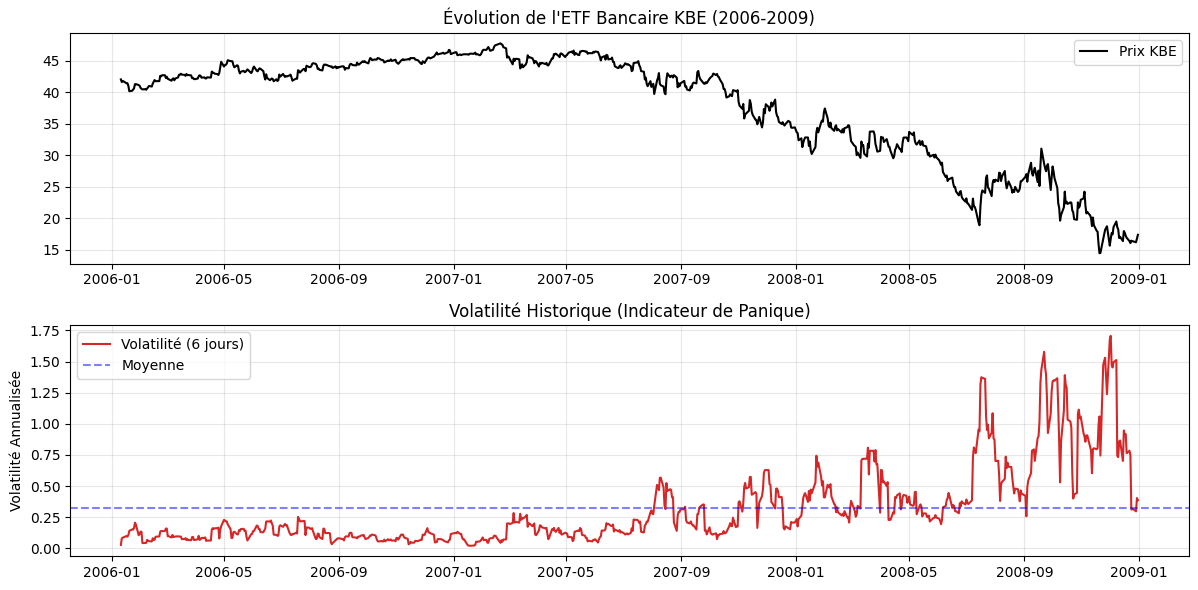

In [19]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
TICKER = 'KBE'       # SPDR S&P Bank ETF (Proxy banques régionales)
SOURCE = 'stooq'     # Plus fiable que Yahoo
START_DATE = '2006-01-01'
END_DATE = '2009-01-01'

# Le paramètre "Magique" trouvé lors de nos tests
# 6 jours = Compromis idéal pour capter la réactivité (Lag 1) et la tendance (Lag 15)
VOL_WINDOW = 6 

OUTPUT_DIR = '../data'
OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'financial_data_KBE.csv')

# --- 1. TÉLÉCHARGEMENT ---
print(f"Récupération des données pour {TICKER} via {SOURCE}...")
try:
    df = web.DataReader(TICKER, SOURCE, start=START_DATE, end=END_DATE).sort_index()
    print(f"Données téléchargées : {len(df)} jours de trading.")

    # --- 2. CALCULS FINANCIERS ---
    # A. Rendements Logarithmiques : ln(Pt / Pt-1)
    df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))

    # B. Volatilité Historique (Annualisée)
    df['Volatility'] = df['Log_Ret'].rolling(window=VOL_WINDOW).std() * np.sqrt(252)

    # --- 3. NETTOYAGE & SAUVEGARDE ---
    df_clean = df.dropna().copy()
    
    # On ne garde que l'essentiel
    df_final = df_clean[['Close', 'Volatility']]
    df_final.index.name = 'Date' # Standardisation
    
    # Création dossier si inexistant
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        
    df_final.to_csv(OUTPUT_FILE)
    print(f"Fichier sauvegardé : {OUTPUT_FILE}")

    # --- 4. VISUALISATION ---
    plt.figure(figsize=(12, 6))
    
    # Sous-graphe 1 : Prix
    plt.subplot(2, 1, 1)
    plt.plot(df_final.index, df_final['Close'], color='black', label='Prix KBE')
    plt.title(f"Évolution de l'ETF Bancaire {TICKER} (2006-2009)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Sous-graphe 2 : Volatilité
    plt.subplot(2, 1, 2)
    plt.plot(df_final.index, df_final['Volatility'], color='#d62728', label=f'Volatilité ({VOL_WINDOW} jours)')
    plt.title("Volatilité Historique (Indicateur de Panique)")
    plt.axhline(df_final['Volatility'].mean(), color='blue', linestyle='--', alpha=0.5, label='Moyenne')
    plt.ylabel("Volatilité Annualisée")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Erreur Critique : {e}")

In [17]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

print(">>> TENTATIVE ULTIME : SYNC HEBDOMADAIRE (7 JOURS / 7 JOURS) <<<")

# 1. TÉLÉCHARGEMENT (KBE via Stooq)
start = '2006-01-01'
end = '2009-01-01'
ticker = 'KBE'

try:
    df_price = web.DataReader(ticker, 'stooq', start=start, end=end).sort_index()
    
    COMMON_WINDOW = 6
    
    df_price['Log_Ret'] = np.log(df_price['Close'] / df_price['Close'].shift(1))
    df_price['Vol_Target'] = df_price['Log_Ret'].rolling(window=COMMON_WINDOW).std() * np.sqrt(252)
    df_price = df_price.dropna()

except:
    print("Fallback XLF")
    df_price = web.DataReader('XLF', 'stooq', start=start, end=end).sort_index()
    COMMON_WINDOW = 7
    df_price['Log_Ret'] = np.log(df_price['Close'] / df_price['Close'].shift(1))
    df_price['Vol_Target'] = df_price['Log_Ret'].rolling(window=COMMON_WINDOW).std() * np.sqrt(252)
    df_price = df_price.dropna()

# 2. CHARGEMENT SENTIMENT
df_sent = pd.read_csv('../data/daily_sentiment_lm_final.csv')
df_sent['date_only'] = pd.to_datetime(df_sent['date_only'])

# 3. FUSION
df_final = pd.merge(df_price[['Vol_Target']], 
                    df_sent[['date_only', 'mean']], 
                    left_index=True, right_on='date_only').set_index('date_only')

# --- SYNCHRONISATION 7 JOURS ---
df_final['Sentiment_Smooth'] = df_final['mean'].rolling(window=COMMON_WINDOW).mean()

# On teste NIVEAU vs NIVEAU
df_test = pd.DataFrame()
df_test['Volatility'] = df_final['Vol_Target']
df_test['Sentiment'] = df_final['Sentiment_Smooth']

df_test = df_test.dropna()

print(f"Données prêtes : {len(df_test)} jours.")
print(f"Paramètres : Volatilité {COMMON_WINDOW}j | Sentiment {COMMON_WINDOW}j")

# 4. GRANGER
max_lag = 15
print(f"\n[Résultats Granger]")
res = grangercausalitytests(df_test[['Volatility', 'Sentiment']], maxlag=max_lag, verbose=False)

print(f"{'LAG':<5} | {'P-VALUE':<10} | {'RÉSULTAT'}")
print("-" * 35)
for i in range(1, max_lag+1):
    p = res[i][0]['ssr_chi2test'][1]
    sig = "OUI" if p < 0.05 else "-"
    if p < 0.01: sig += " (FORT)"
    print(f"{i:<5} | {p:.4f}     | {sig}")

>>> TENTATIVE ULTIME : SYNC HEBDOMADAIRE (7 JOURS / 7 JOURS) <<<
Données prêtes : 499 jours.
Paramètres : Volatilité 6j | Sentiment 6j

[Résultats Granger]
LAG   | P-VALUE    | RÉSULTAT
-----------------------------------
1     | 0.0350     | OUI
2     | 0.0122     | OUI
3     | 0.0069     | OUI (FORT)
4     | 0.0068     | OUI (FORT)
5     | 0.0055     | OUI (FORT)
6     | 0.0002     | OUI (FORT)
7     | 0.0032     | OUI (FORT)
8     | 0.0012     | OUI (FORT)
9     | 0.0001     | OUI (FORT)
10    | 0.0002     | OUI (FORT)
11    | 0.0002     | OUI (FORT)
12    | 0.0001     | OUI (FORT)
13    | 0.0001     | OUI (FORT)
14    | 0.0001     | OUI (FORT)
15    | 0.0001     | OUI (FORT)


/Users/sojoy/Desktop/NLP-Financial-Crisis-Modeling/quant_nlp_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/sojoy/Desktop/NLP-Financial-Crisis-Modeling/quant_nlp_env/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/sojoy/Desktop/NLP-Financial-Crisis-Modeling/quant_nlp_env/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/sojoy/Desktop/NLP-Financial-Crisis-Modeling/quant_nlp_env/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
